In [8]:
%load_ext autoreload
%autoreload 2

import os
import json
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import ray_results_interpreter as rri
import subprocess
import concurrent.futures
from main_run import MainRun

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
def collect_data_and_plot(df, test_mode, setting_name):
    def get_identifier(row):
        return f"{row['Architecture Class']}_{row['store_underage_cost']}_{row['store_lead_time']}"

    def get_file_name(row):
        return f"results/{row['# of stores']}/{get_identifier(row)}.csv"

    def run_main_run(row):
        try:
            cmd = [
                "/user/ml4723/.conda/envs/neural_inventory_control/bin/python",
                "main_run.py",
                test_mode, # test or test_on_dev
                setting_name,
                row['hyperparam_name'],
                row['path'],
                get_identifier(row)
            ]
            env = {
                **os.environ,
                "MKL_THREADING_LAYER": "GNU",
                "MKL_SERVICE_FORCE_INTEL": "1"
            }
            subprocess.run(cmd, capture_output=True, text=True, check=True, env=env, cwd="/user/ml4723/Prj/NIC/")
        except subprocess.CalledProcessError as e:
            print(f"Error running main_run.py for path {row['path']}: {e}")
            print(f"Error output: {e.stderr}")
        except Exception as e:
            print(f"Unexpected error running main_run.py for path {row['path']}: {e}")

    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        for _, row in df.iterrows():
            file_name = get_file_name(row)
            if os.path.exists(file_name):
                continue
            while len(futures) >= 10:
                done, not_done = concurrent.futures.wait(
                    futures, 
                    return_when=concurrent.futures.FIRST_COMPLETED
                )
                futures = list(not_done)
            futures.append(executor.submit(run_main_run, row))
        concurrent.futures.wait(futures)
    
    avg_s_underage = []
    avg_s_holding = []
    avg_w_holding = []
    avg_e1_holding = []
    avg_e2_holding = []
    avg_cost = []
    for _, row in df.iterrows():
        file_name = get_file_name(row)
        data = pd.read_csv(file_name)
        n_samples = 32768
        batch_size = 32768
        num_batches = n_samples // batch_size
        num_steps = 500
        start_step = 300
        
        relevant_indices = []
        for batch in range(num_batches):
            batch_start = batch * batch_size * num_steps
            step_start = batch_start + start_step * batch_size
            step_end = batch_start + num_steps * batch_size
            relevant_indices.extend(range(step_start, step_end))
        relevant_data = data.iloc[relevant_indices]
        
        n_stores = row['# of stores']
        avg_s_underage.append(relevant_data['s_underage_costs'].mean() / row['store_underage_cost'])
        avg_s_holding.append(relevant_data['s_holding_costs'].mean() / row['store_underage_cost'])
        avg_w_holding.append(relevant_data['w_holding_costs'].mean() / row['store_underage_cost'])
        avg_e1_holding.append(relevant_data['e1_holding_costs'].mean() / row['store_underage_cost'])
        avg_e2_holding.append(relevant_data['e2_holding_costs'].mean() / row['store_underage_cost'])
        total_cost = (relevant_data['s_underage_costs'].sum() * n_stores + 
                     relevant_data['s_holding_costs'].sum() * n_stores + 
                     relevant_data['w_holding_costs'].sum() +
                     relevant_data['e1_holding_costs'].sum() +
                     relevant_data['e2_holding_costs'].sum())
        avg_cost.append(total_cost)

    df_copy = df.copy()
    df_copy['avg_s_underage'] = avg_s_underage
    df_copy['avg_s_holding'] = avg_s_holding
    df_copy['avg_w_holding'] = avg_w_holding
    df_copy['avg_e1_holding'] = avg_e1_holding
    df_copy['avg_e2_holding'] = avg_e2_holding
    df_copy['avg_cost'] = avg_cost
    df = df_copy

    # Create subplots for each lead time
    lead_times = sorted(df['store_lead_time'].unique())
    metrics = ['avg_s_underage', 'avg_s_holding', 'avg_w_holding', 'avg_e1_holding', 'avg_e2_holding']
    metric_titles = ['Store Underage Cost', 'Store Holding Cost', 'Warehouse Holding Cost', 
                    'Echelon 1 Holding Cost', 'Echelon 2 Holding Cost']
    
    fig, axes = plt.subplots(len(lead_times), len(metrics), figsize=(20, 4*len(lead_times)))
    
    for i, lead_time in enumerate(lead_times):
        df_lt = df[df['store_lead_time'] == lead_time]
        underage_costs = sorted(df_lt['store_underage_cost'].unique())
        
        for j, (metric, title) in enumerate(zip(metrics, metric_titles)):
            ax = axes[i][j]
            
            for arch in df_lt['Architecture Class'].unique():
                if arch == 'Just_In_Time':
                    continue
                    
                values = []
                for uc in underage_costs:
                    mask = (df_lt['Architecture Class'] == arch) & (df_lt['store_underage_cost'] == uc)
                    if len(df_lt[mask]) > 0:
                        values.append(df_lt[mask][metric].mean())
                
                if values:
                    ax.plot(underage_costs, values, marker='o', label=arch)
            
            ax.set_xlabel('Store Underage Cost')
            ax.set_ylabel(f'Average {title}')
            ax.set_title(f'Lead Time {lead_time}: {title}')
            ax.legend()
            ax.grid(True)
            ax.set_xticks(underage_costs)
    
    plt.tight_layout()
    plt.show()
    return df


In [9]:
# Create vanilla results dataframe from the provided data
vanilla_data = []
for lead_time in [1, 2, 3, 4]:
    for underage_cost in [4, 9, 19, 39]:
        # Find matching row in provided data
        row = {
            'store_lead_time': lead_time,
            'store_underage_cost': underage_cost,
            'Architecture Class': 'paper_result',
            'Test Loss': None
        }
        # Match with provided data and set test loss
        if lead_time == 1 and underage_cost == 4:
            row['Test Loss'] = 6.91
        elif lead_time == 1 and underage_cost == 9:
            row['Test Loss'] = 8.38
        elif lead_time == 1 and underage_cost == 19:
            row['Test Loss'] = 9.63
        elif lead_time == 1 and underage_cost == 39:
            row['Test Loss'] = 10.72
        elif lead_time == 2 and underage_cost == 4:
            row['Test Loss'] = 7.61
        elif lead_time == 2 and underage_cost == 9:
            row['Test Loss'] = 9.28
        elif lead_time == 2 and underage_cost == 19:
            row['Test Loss'] = 10.70
        elif lead_time == 2 and underage_cost == 39:
            row['Test Loss'] = 11.99
        elif lead_time == 3 and underage_cost == 4:
            row['Test Loss'] = 8.22
        elif lead_time == 3 and underage_cost == 9:
            row['Test Loss'] = 10.06
        elif lead_time == 3 and underage_cost == 19:
            row['Test Loss'] = 11.61
        elif lead_time == 3 and underage_cost == 39:
            row['Test Loss'] = 13.01
        elif lead_time == 4 and underage_cost == 4:
            row['Test Loss'] = 8.78
        elif lead_time == 4 and underage_cost == 9:
            row['Test Loss'] = 10.76
        elif lead_time == 4 and underage_cost == 19:
            row['Test Loss'] = 12.45
        elif lead_time == 4 and underage_cost == 39:
            row['Test Loss'] = 13.97
        vanilla_data.append(row)
vanilla_df = pd.DataFrame(vanilla_data)

In [10]:
# Define color scheme for architecture types
color_scheme = {
    "GNN_MP_serial": "#ff7f0e",  # Orange
    "paper_result": "#9467bd",  # Purple
    "vanilla_serial": "#1f77b4"  # Blue
}

linestyle_scheme = {
    "GNN_MP_serial": "-",  # Solid
    "paper_result": "-",  # Solid
    "vanilla_serial": "-"  # Solid
}

testset_name = "generic_architecture_serial"

# Define paths for each architecture
architectures = {
    "GNN_MP_serial": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_MP_serial'
}

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    return None

sort_by = 'test_loss'
pick_row_from_run_by = 'test_loss'

results_interpretor = rri.RayResultsinterpreter()

# Create dataframes for each architecture and parameter combination
dfs = []
params = {
    'store_lead_time': [1, 2, 3, 4],
    'store_underage_cost': [4, 9, 19, 39]
}
dfs.append(vanilla_df)

for arch_name, path in architectures.items():
    for lead_time in params['store_lead_time']:
        for underage_cost in params['store_underage_cost']:
            df = results_interpretor.make_table({1: path},
                {'store_lead_time': lead_time,
                 'store_underage_cost': underage_cost,
                 'samples': [1,2,3]},
                default_condition_setter, custom_data_filler, 
                sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
            if df.empty:
                continue
            
            df.insert(2, 'Architecture Class', arch_name)
            df.insert(1, 'hyperparam_name', arch_name)
            df['store_lead_time'] = lead_time
            df['store_underage_cost'] = underage_cost
            dfs.append(df)

# Combine all dataframes
df = pd.concat(dfs, ignore_index=True)

# Calculate test gap percentage
min_test_loss = df.groupby(['store_lead_time', 'store_underage_cost'])['Test Loss'].transform('min')
df['Test Gap %'] = ((df['Test Loss'] - min_test_loss) / min_test_loss) * 100


print("\nDataframe Summary:")
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)        # Don't wrap wide displays
pd.set_option('display.float_format', lambda x: '%.3f' % x)  # Format floats to 3 decimal places

# Sort and select columns
# Calculate mean and variance of test loss grouped by lead time, underage cost and architecture class
variance_df = df.groupby(['store_lead_time', 'store_underage_cost', 'Architecture Class'])['Test Loss'].agg(['mean', 'var']).reset_index()
variance_df.columns = ['store_lead_time', 'store_underage_cost', 'Architecture Class', 'Mean Test Loss', 'Test Loss Variance']

# Round variance to 6 decimal places
variance_df['Test Loss Variance'] = variance_df['Test Loss Variance'].round(6)
variance_df['Mean Test Loss'] = variance_df['Mean Test Loss'].round(6)

# Merge mean and variance back into main dataframe
df_sorted = df.merge(
    variance_df, 
    on=['store_lead_time', 'store_underage_cost', 'Architecture Class'],
    how='left'
).sort_values(['store_lead_time', 'store_underage_cost'])

columns = ['store_lead_time', 'store_underage_cost', 'Architecture Class',
          'Train Loss', 'Dev Loss', 'Test Loss', 'Test Gap %', 
          'Mean Test Loss', 'Test Loss Variance']
df_sorted = df_sorted.loc[df_sorted.groupby(['store_lead_time', 'store_underage_cost', 'Architecture Class'])['Test Loss'].idxmin()]
print(df_sorted[columns].to_string(index=False))

df = df_sorted

# Create 2x2 subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
axes = [ax1, ax2, ax3, ax4]

# Plot for each lead time
for idx, lead_time in enumerate(params['store_lead_time']):
    lead_time_df = df[df['store_lead_time'] == lead_time]
    
    for arch in df['Architecture Class'].unique():
        arch_data = lead_time_df[lead_time_df['Architecture Class'] == arch]
        x = arch_data['store_underage_cost'].values
        y = arch_data['Test Gap %'].values
        # Sort x and y based on x values
        sort_idx = np.argsort(x)
        x = x[sort_idx]
        y = y[sort_idx]
        
        axes[idx].plot(x, y,
                      marker='o', 
                      label=arch,
                      color=color_scheme[arch],
                      linestyle=linestyle_scheme[arch])
    
    axes[idx].set_title(f'Lead Time = {lead_time}')
    axes[idx].set_xlabel('Store Underage Cost')
    axes[idx].set_ylabel('Test Gap %')
    axes[idx].grid(True)
    axes[idx].legend()


plt.tight_layout()
plt.show()


Dataframe Summary:


KeyError: "['Train Loss', 'Dev Loss'] not in index"

In [11]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
print(df)
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.width')
pd.reset_option('display.max_colwidth')


    # of stores                hyperparam_name  store_lead_time  \
48            1  GNN_MP_serial_merged_residual                1   
0             1                 vanilla_serial                1   
52            1  GNN_MP_serial_merged_residual                1   
3             1                 vanilla_serial                1   
56            1  GNN_MP_serial_merged_residual                1   
6             1                 vanilla_serial                1   
59            1  GNN_MP_serial_merged_residual                1   
11            1                 vanilla_serial                1   
60            1  GNN_MP_serial_merged_residual                2   
13            1                 vanilla_serial                2   
64            1  GNN_MP_serial_merged_residual                2   
15            1                 vanilla_serial                2   
66            1  GNN_MP_serial_merged_residual                2   
18            1                 vanilla_serial                

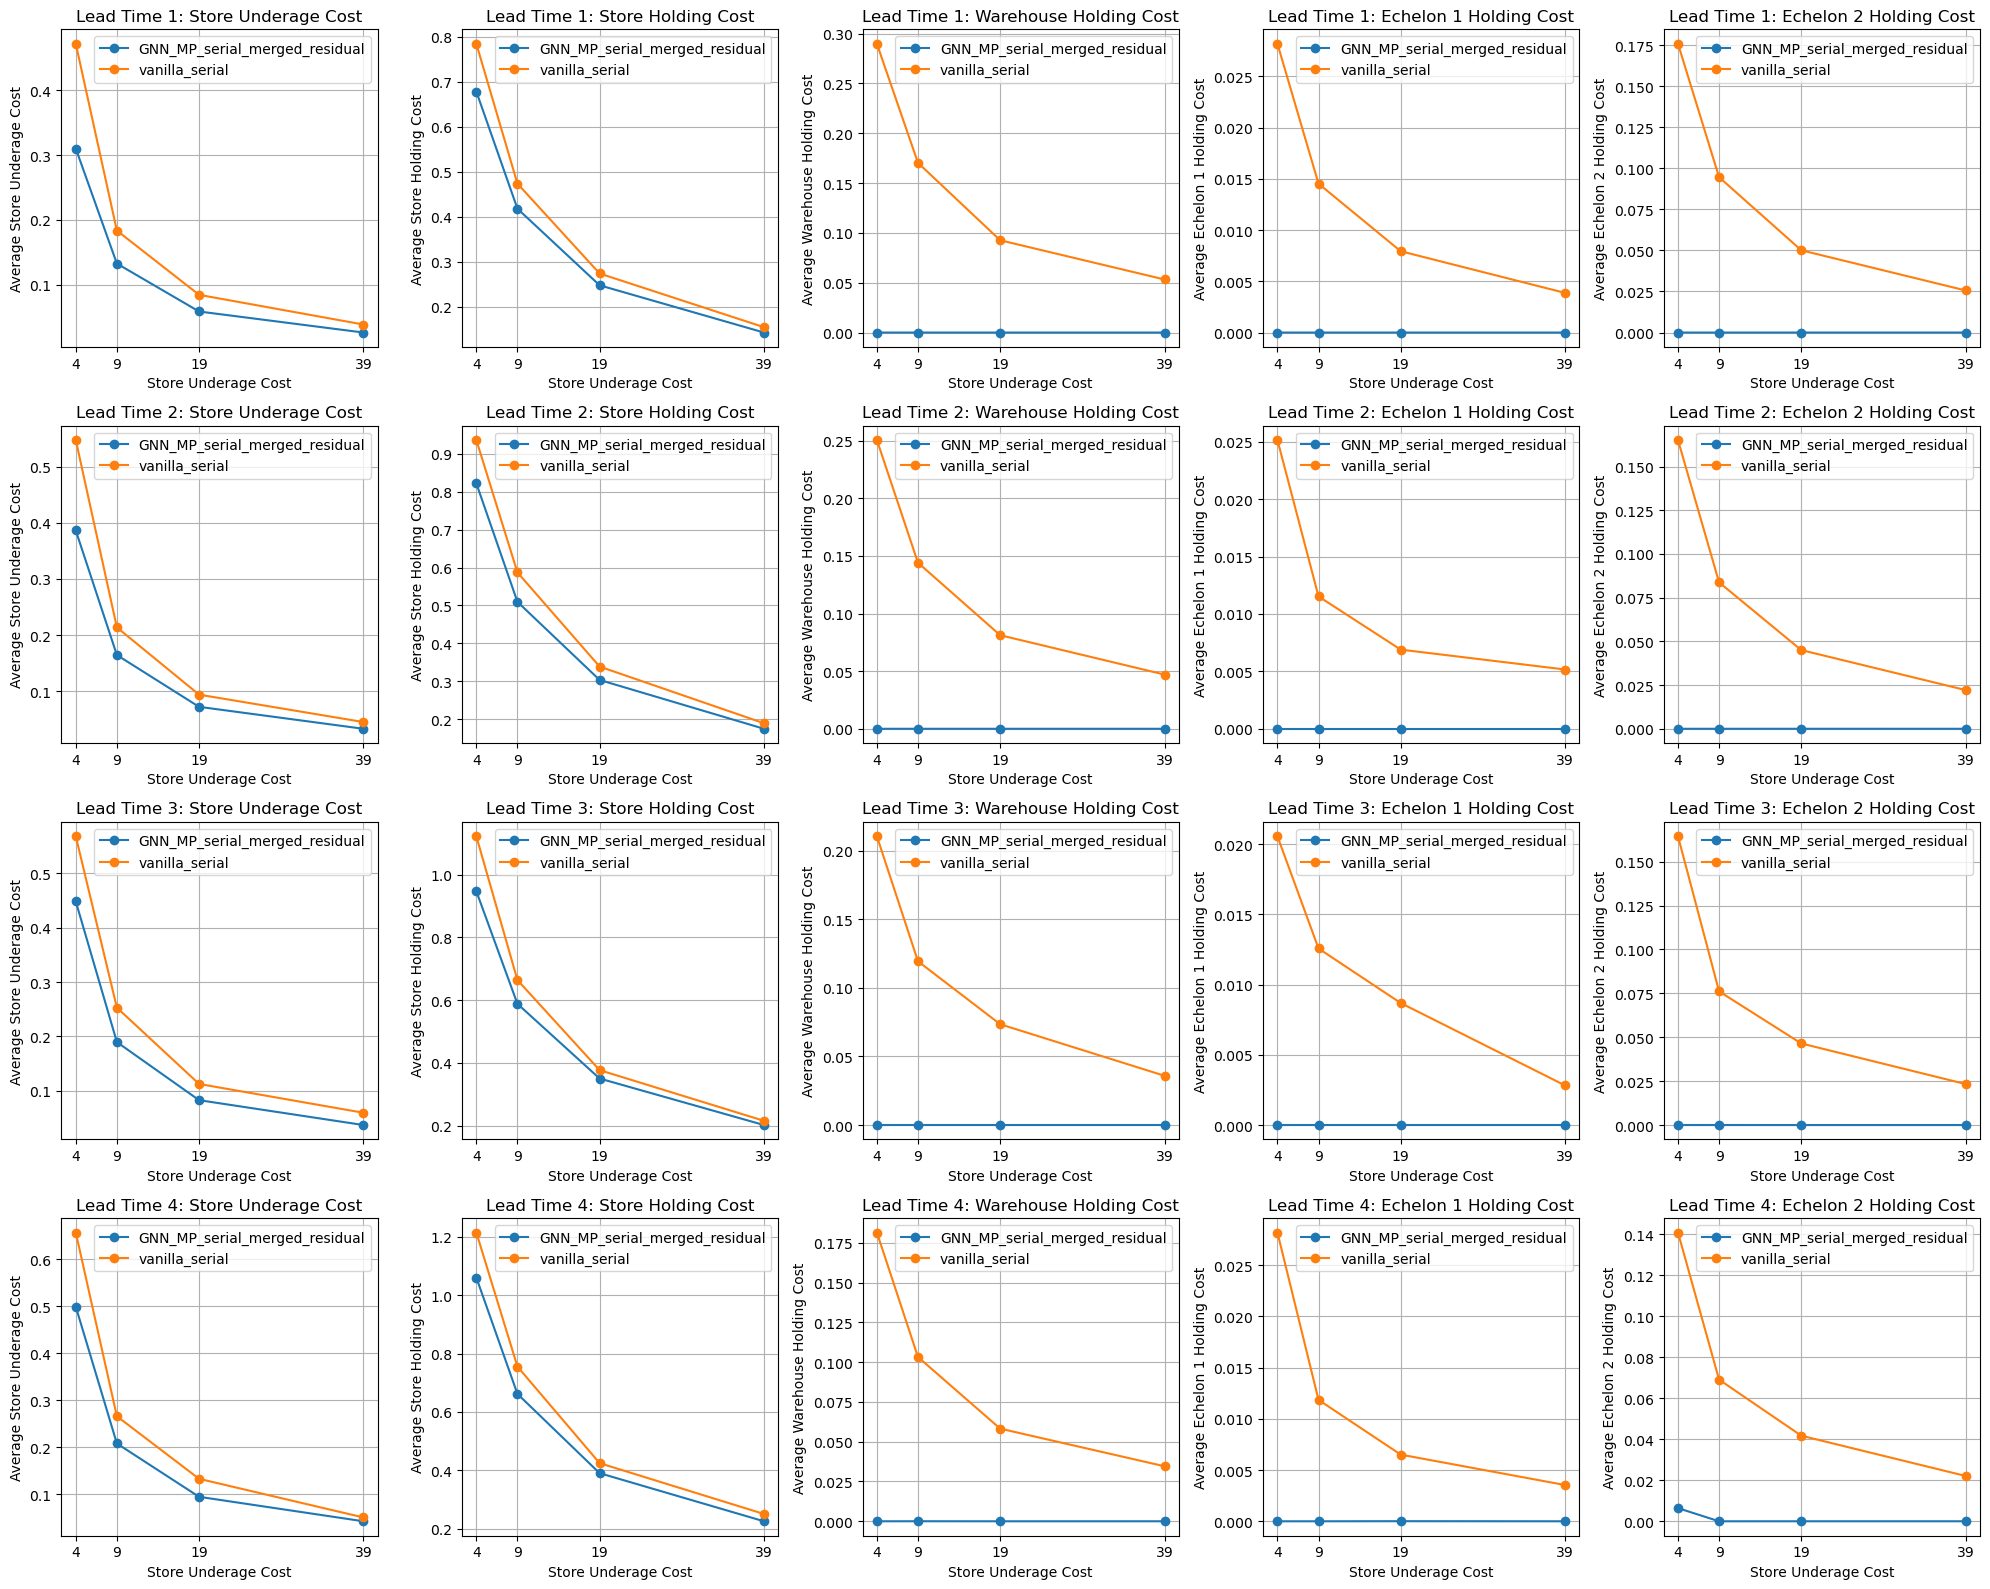

In [14]:
df_t = collect_data_and_plot(df, "test", "serial_system")